In [21]:
import requests, json
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime
from urllib.parse import quote

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import folium

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# path = 'C:/Users/YOnSAI/AppData/Local/Microsoft/Windows/Fonts' 
# fm.fontManager.addfont(path + '/D2Coding-Ver1.3.2-20180524.ttf')
# plt.rcParams['font.family'] = 'D2Coding'


- 경기 남부 경찰청 홈페이지에서 경찰서 정보찾기

In [22]:
kakao_url = 'https://dapi.kakao.com/v2/local/search/address.json'

with open('../04.지도시각화/data/kakaoapikey.txt') as f:
    kakao_key = f.read()

kakao_header = {'Authorization': f'KakaoAK {kakao_key}'}

In [23]:
base_url = 'https://www.ggpolice.go.kr/main/html.do?menu=HC44'
soup = BeautifulSoup(requests.get(base_url).text, 'html.parser')

In [24]:

lis = soup.select('.road')
lines = []
for li in tqdm(lis):
    sub_url = li.select_one('a')['href']
    sub_soup = BeautifulSoup(requests.get(sub_url).text, 'html.parser')
    

    infos = sub_soup.select('.basic_list7 > li')
    # 이름과 주소가 없는 경우도 있다.
    if len(infos) == 0:
        continue

    name = infos[0].get_text().split(' : ')[-1].strip()
    addr = infos[1].get_text().split(' : ')[-1]
    addr = addr.split('(')[0].strip()
    
    # 주소로 위도, 경도 가져오기
    url = f'{kakao_url}?query={quote(addr)}'
    result = requests.get(url, headers=kakao_header).json()

    x_cor = float(result['documents'][0]['y'])
    y_cor = float(result['documents'][0]['x'])
    
    lines.append({'경찰서': name, '주소': addr, '위도': x_cor, '경도': y_cor})   

df = pd.DataFrame(lines)
df.head()
    

100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


,경찰서,주소,위도,경도
0,수원중부경찰서,경기도 수원시 장안구 정자천로 199,37.297932,126.996317
1,수원남부경찰서,경기 수원시 영통구 매봉로 52,37.272104,127.054492
2,수원서부경찰서,경기 수원시 권선구 서부로 1673,37.258740,126.972264
3,안양동안경찰서,경기도 안양시 동안구 동안로159번길 43,37.391209,126.948866
4,안양만안경찰서,경기도 안양시 만안구 냉천로 63,37.387334,126.925974


In [25]:
df.to_csv('data/경기남부경찰서.csv', index=False)

- 지도 표시


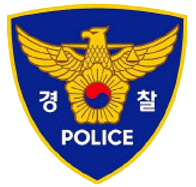
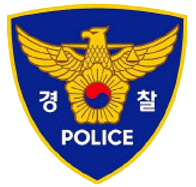
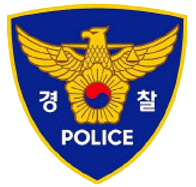
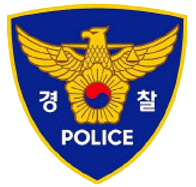
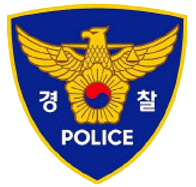
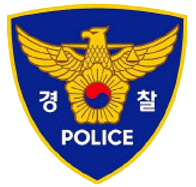
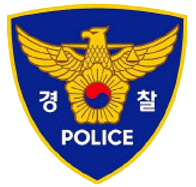
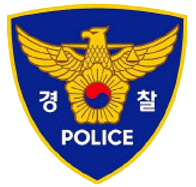
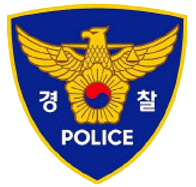
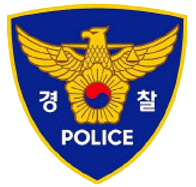
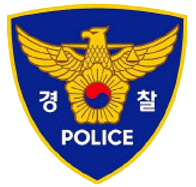
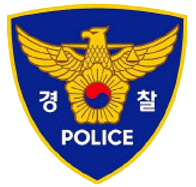
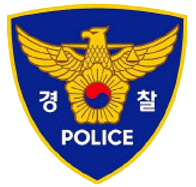
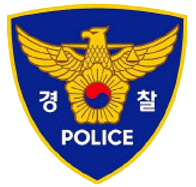
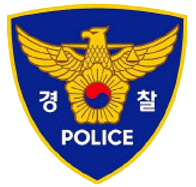
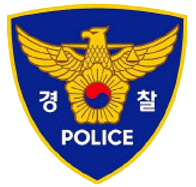
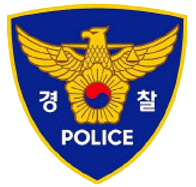
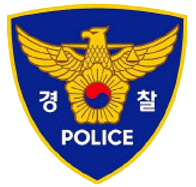
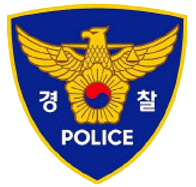
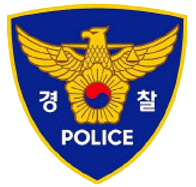
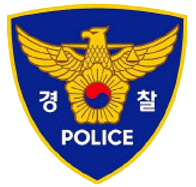
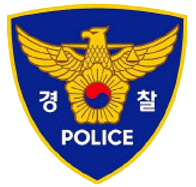
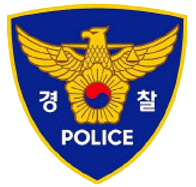
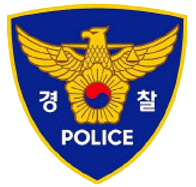
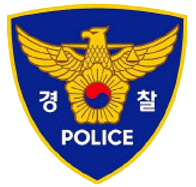
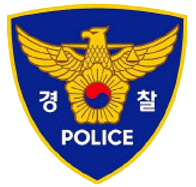
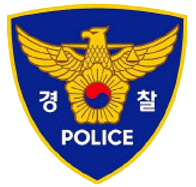
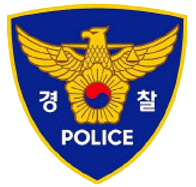
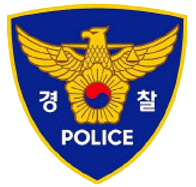

In [26]:
pmap = folium.Map(location=[df.위도.mean(), df.경도.mean()], zoom_start=10)
for i in df.index:
    folium.Marker(
        location=[df.위도[i], df.경도[i]], 
        popup=folium.Popup(df.주소[i], max_width=200),
        tooltip=df.경찰서[i],
        icon=folium.CustomIcon('data/police_icon.png', icon_size=(30, 30))
    ).add_to(pmap)

title_html = '<h3 align="center" style="font-size:20px;">경기 남부 경찰관서</h3>'
pmap.get_root().html.add_child(folium.Element(title_html))
pmap